In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import os.path as osp
import sys
import glob
import time
import timeit
import math
import random

import itertools
from collections import OrderedDict

import re
from lxml import etree
from tqdm import tqdm, tnrange, tqdm_notebook

import numpy as np
import pandas as pd
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split, Subset

from draw import show_img, show_img_grid
from utils import postprocessing, letterbox_transforms, letterbox_label_reverse, fill_label_np_tensor
from boundingbox import CoordinateType, FormatType, BoundingBoxConverter
from transforms import IaaAugmentations, IaaLetterbox, ToTensor, Compose, \
                       iaa_hsv_aug, iaa_random_crop, iaa_letterbox
from dataset import CVATDataset, ImageFolderDataset, DataHelper
from dataset import worker_init_fn, variable_shape_collate_fn

from test import *
from train import *

In [2]:
seed = 0

def set_seed(seed):
    cudnn.benchmark = False
    cudnn.deterministic = True

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seed(seed)

# Paths

In [3]:
weight_path = './yolov3.weights'
backbone_weight_path = './darknet53.conv.74'
classes_path = './x_wing.names'
classes_names = ['x_wing', 'tie']
cvat_img_dir = './custom_data/x_wing'
label_xml_path = './custom_data/7_x_wing.xml'
output_dir = './output'

In [4]:
cv2.setNumThreads(0)

# Training

## Set up dataloader

In [5]:
def getTransforms(dim, aug=True):
    if aug:
        transform = Compose([IaaAugmentations([iaa_hsv_aug(0.1, 1.5, 1.5),
                                               iaa_random_crop(0.3),
                                               iaa.Fliplr(0.5),
                                               iaa.Scale(dim)
                                              ]),
                             ToTensor()])
    else:
        transform = Compose([IaaAugmentations([IaaLetterbox(dim),
                                              ]),
                             ToTensor()])
    return transform

In [6]:
def get_trans_fn(aug):
    def getTransformByDim(dim):
        return getTransforms(dim, aug=aug)
    return getTransformByDim

In [7]:
def getCVATData(seed, cvat_img_dir, label_xml_path, bs, aug=True,
                subset_idx=None, shuffle=True, cyclic=True, dim=None, rand_dim_interval=None,
                max_net_batches=None, net_subdivisions=1):
    torch.manual_seed(seed)
    cvat_trans_fn = get_trans_fn(aug)
    cvat_ds = CVATDataset(cvat_img_dir, label_xml_path, bs, subset_idx=subset_idx, trans_fn=cvat_trans_fn,
                          shuffle=shuffle, cyclic=cyclic, dim=dim, rand_dim_interval=rand_dim_interval)
    cvat_dl = DataLoader(cvat_ds, batch_size=bs, shuffle=False, num_workers=4, worker_init_fn=worker_init_fn, collate_fn=variable_shape_collate_fn)
    cvat_data = DataHelper(cvat_ds, cvat_dl, current_batch=0, max_net_batches=max_net_batches, net_subdivisions=net_subdivisions)
    return cvat_data

## Initial training

In [8]:
seed = 0
sz = 416
dim = (sz, sz)
# Optimizer parameters
ratio = 1
lr = 0.001 / ratio
backbone_lr = 0.0001 / ratio
momentum = 0.9
wd = 0.0005
freeze_backbone = False
# Network paramters. Increase subdivisions if GPU don't have enough memory
net_bs = 64
net_subdivisions = 8
bs = int(net_bs / net_subdivisions)
# Change image dimension every 10 net_batch -> 80 mini-batch
random_dim_interval = net_bs * 10
# Save interval in units of net batch
checkpoint_interval = 20 #100
# Maximum net batches to train
max_net_batches = 1000# 500200

In [ ]:
model_id = 'x_wing_rand_7'
weight_dir = './weights'

remove_checkpoints(model_id, weight_dir)

set_seed(seed)
net = YoloNet((sz, sz), numClass=2).cuda()
net.feature.loadWeight(backbone_weight_path)

data = getCVATData(seed, cvat_img_dir, label_xml_path, bs, aug=True,
                   subset_idx=None, shuffle=True, cyclic=True, dim=dim, rand_dim_interval=random_dim_interval,
                   max_net_batches=max_net_batches, net_subdivisions=net_subdivisions)
optimizer = get_optimizer(net, lr, backbone_lr, wd, momentum, freeze_backbone)
recorder = Recorder()


train(data, net, optimizer, recorder,
      model_id=model_id, weight_dir=weight_dir,
      checkpoint=None, checkpoint_interval=checkpoint_interval,
      use_gpu=True) 

## Resume training (make sure 'model_id' matches)

In [8]:
def resume_training(max_net_batches, model_id, weight_dir):
    checkpoint_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir)
    #pt_weight_path = './weights/x_wing_rand_1/yolov3_x_wing_rand_1_checkpoint_0159.pth.tar'
    if checkpoint_path is None:
        print('No checkpoint for %s found' % model_id)
        return

    print('Loading %s' % checkpoint_path)
    checkpoint = load_checkpoint(checkpoint_path)

    data = getCVATData(seed, cvat_img_dir, label_xml_path, bs, aug=True,
               subset_idx=None, shuffle=True, cyclic=True, dim=None, rand_dim_interval=random_dim_interval,
               max_net_batches=max_net_batches, net_subdivisions=net_subdivisions)
    net = YoloNet((sz, sz), numClass=2).cuda()
    optimizer = get_optimizer(net, lr, backbone_lr, wd, momentum, freeze_backbone)
    recorder = Recorder()

    train(data, net, optimizer, recorder,
          model_id=model_id, weight_dir=weight_dir,
          checkpoint=checkpoint, checkpoint_interval=checkpoint_interval,
          use_gpu=True) 


In [9]:
seed = 0
sz = 416
dim = (sz, sz)
# Optimizer parameters
ratio = 1
lr = 0.001 / ratio
backbone_lr = 0.001 / ratio
momentum = 0.9
wd = 0.0005
freeze_backbone = False
# Network paramters. Increase subdivisions if GPU don't have enough memory
net_bs = 64
net_subdivisions = 8
bs = int(net_bs / net_subdivisions)
# Change image dimension every 10 net_batch -> 40 mini-batch
random_dim_interval = net_bs * 10
# Save interval in units of net batch
checkpoint_interval = 20 #100
# Maximum net batches to train
max_net_batches = 1000# 500200

In [ ]:
model_id = 'x_wing_rand_7'
weight_dir = './weights'

set_seed(seed)
resume_training(max_net_batches, model_id, weight_dir)

## Test model on images

## Helper functions

In [8]:
def letterbox_reverse(labels, org_w, org_h, new_w, new_h):
    if len(labels) == 0:
        return labels
    
    if isinstance(labels, torch.Tensor):
        labels = labels.clone()
    elif isinstance(labels, np.ndarray):
        labels = labels.copy()
    else:
        raise TypeError("Labels must be a numpy array or pytorch tensor")

    ratio = min(new_w / org_w, new_h / org_h)
    resize_w, resize_h = int(org_w * ratio), int(org_h * ratio)
    x_pad, y_pad = (new_w - resize_w) // 2, (new_h - resize_h) // 2

    mask = labels.sum(-1) != 0
    labels[mask, 0] = (labels[mask, 0] - x_pad) / ratio
    labels[mask, 2] = (labels[mask, 2] - x_pad) / ratio
    labels[mask, 1] = (labels[mask, 1] - y_pad) / ratio
    labels[mask, 3] = (labels[mask, 3] - y_pad) / ratio

    return labels

def letterbox_reverse_on_batches(labels, params, bbs_idx=np.array([0,1,2,3])):
    nb_images = len(labels)
    for i in range(nb_images):
        labels[i] = letterbox_reverse(labels[i], *params[i])
    return labels

def prep_img_for_opencv(img_list):
    img_list = img_list.permute(0,2,3,1) * 255
    img_list = img_list.numpy().astype(np.uint8)
    return img_list


## Parameters

In [9]:
seed = 0
sz = 416
dim = (sz, sz)
bs = 8

weight_dir = './weights'

model_id = 'x_wing_rand_7'
weight_dir = './weights'
output_dir = './output/' + model_id
output_img_dir = output_dir + '/img'
output_label_dir = output_dir + '/label'

classes_names = ['x_wing', 'tie']

## Run the model and show the detections on images

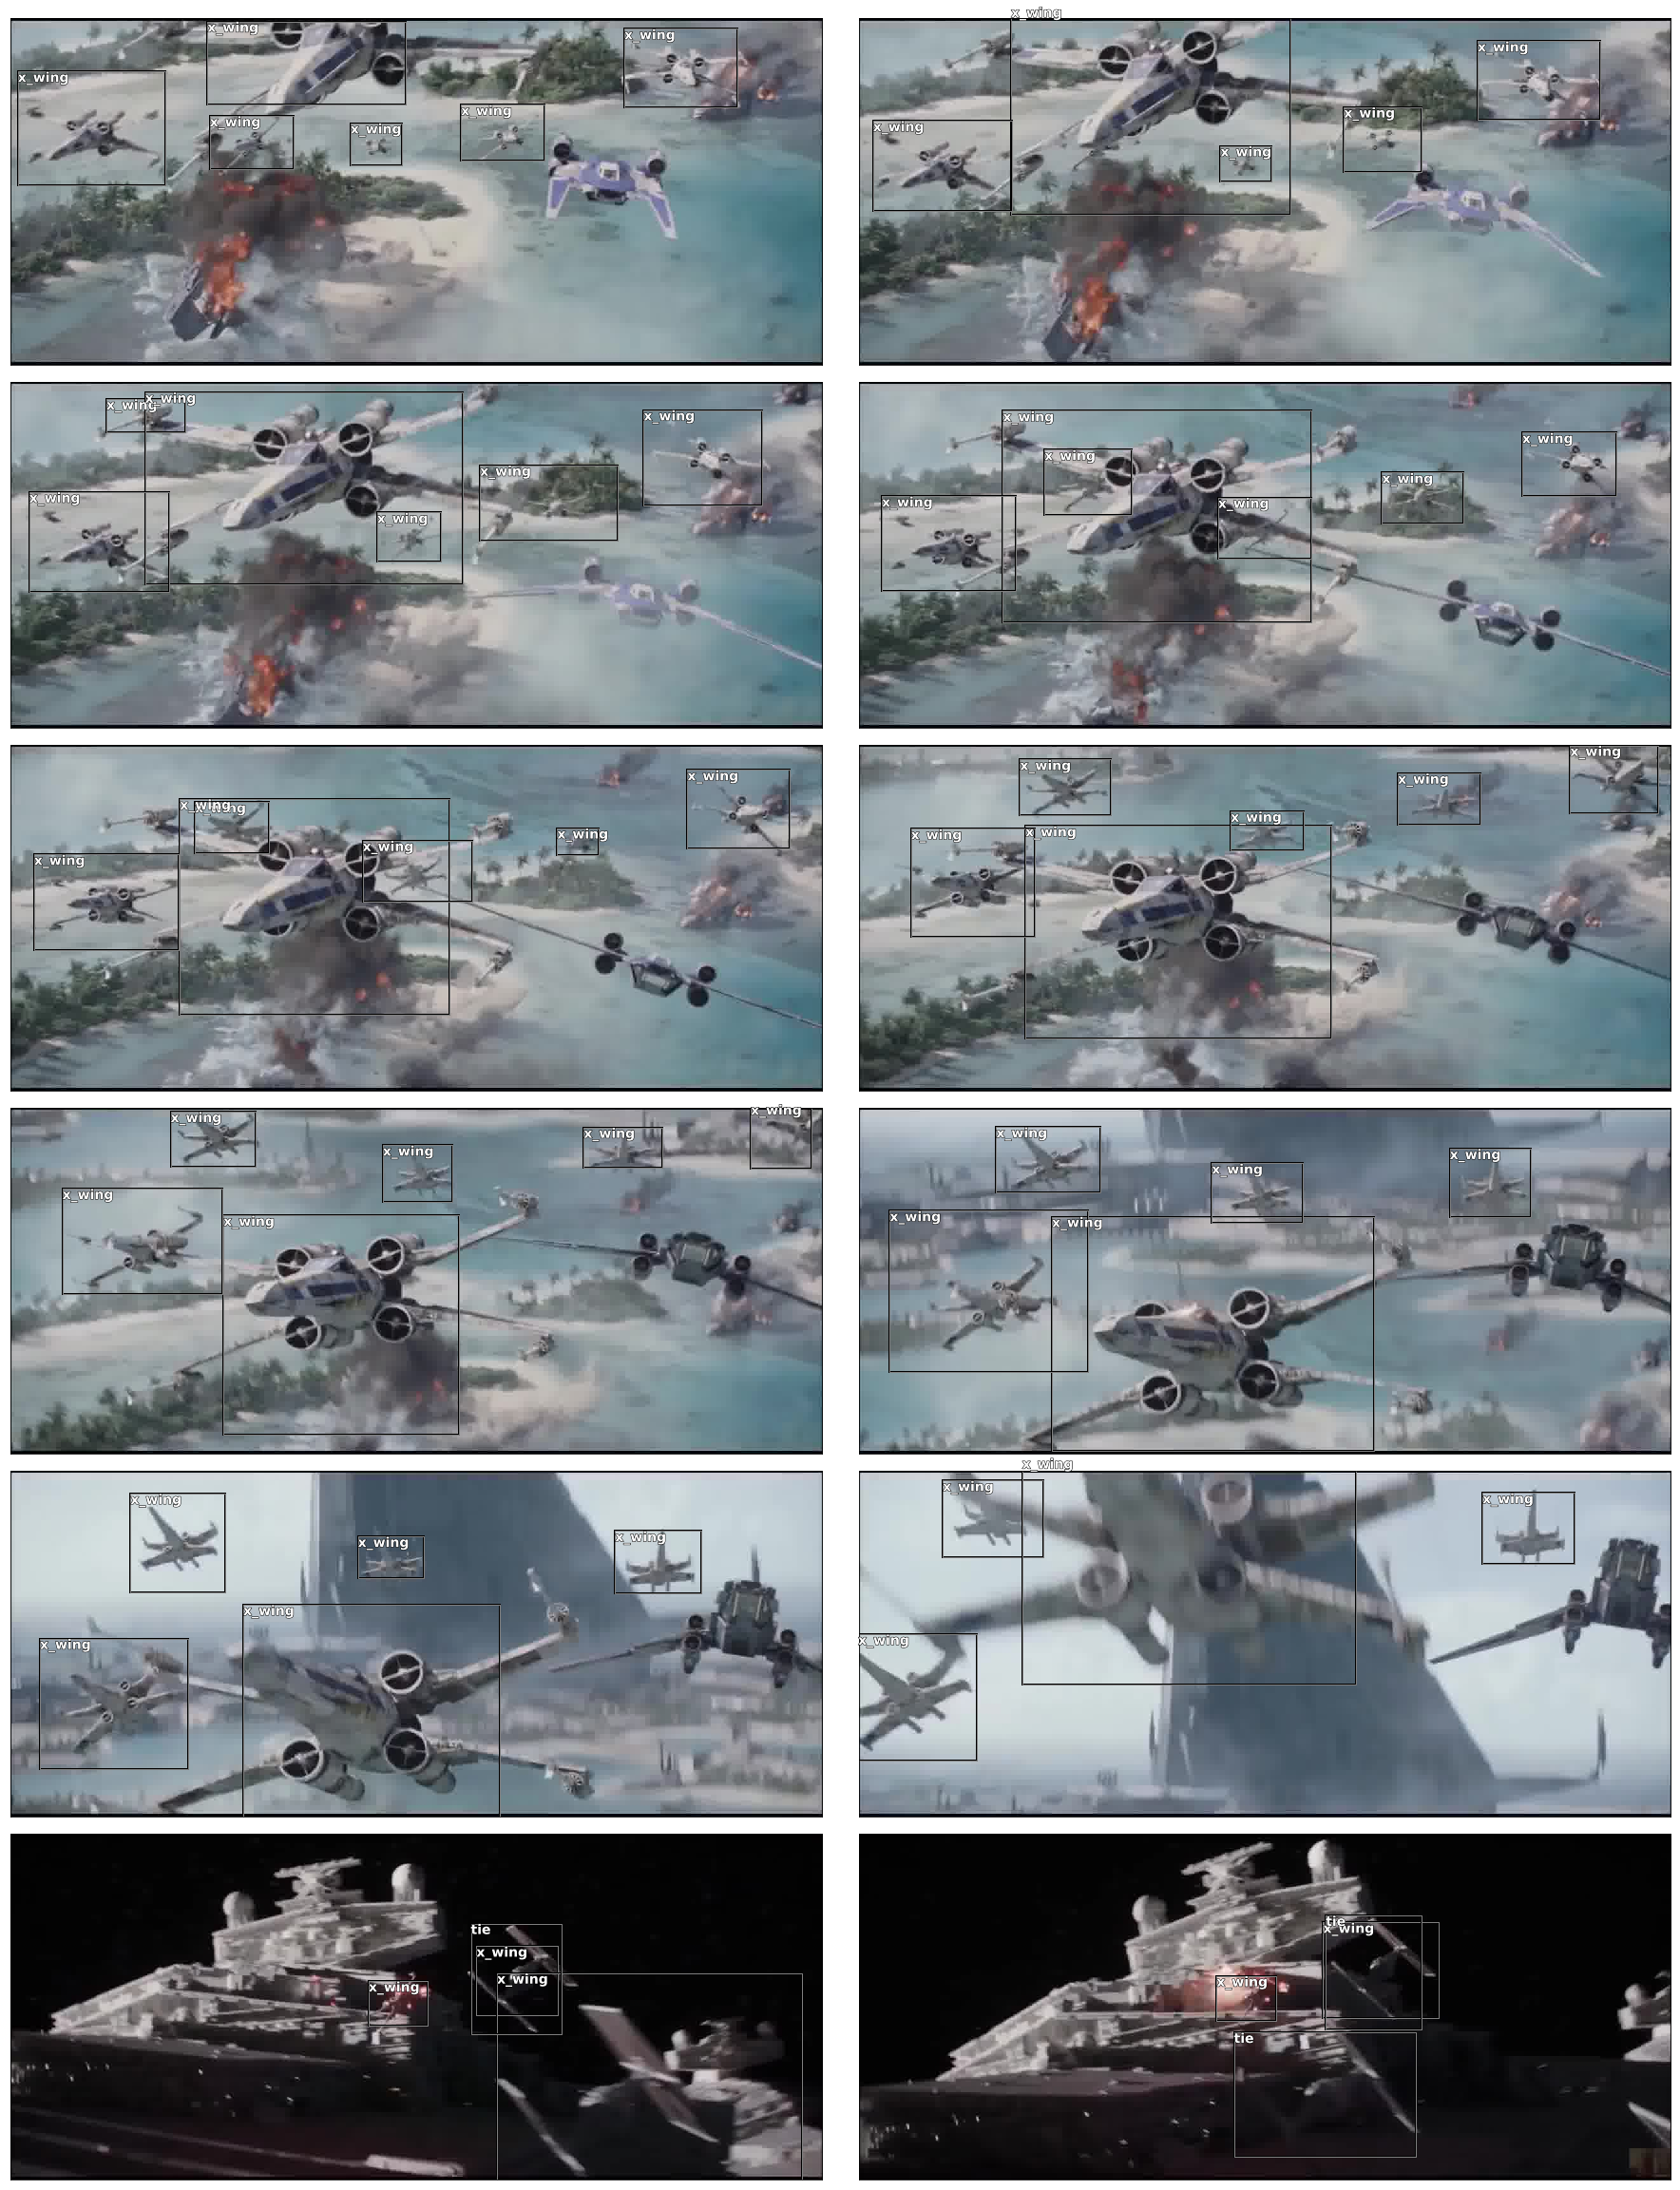

In [10]:
# Display subset of the training set
start = 200
subset_idx = np.arange(start, start + 12)

checkpoint = load_checkpoint(get_latest_checkpoint(model_id, weight_dir)[0])
data = getCVATData(4, cvat_img_dir, label_xml_path, bs, aug=False,
                   subset_idx=subset_idx, shuffle=False, cyclic=False, dim=dim, rand_dim_interval=None,
                   max_net_batches=None, net_subdivisions=1)
net = YoloNet(dim, numClass=2).cuda().eval()
net.load_state_dict(checkpoint['net'])

show_detections(data, net, classes_names)

## Save detections to images and text file

In [11]:
from pathlib import Path

def save_detections(save_path, labels, inp_fmt="x1 y1 x2 y2 conf cls clsId", out_fmt="clsId conf x1 y1 x2 y2"):
    if len(labels) == 0:
        return

    inp_dict = {v:i for i,v in enumerate(inp_fmt.split(' '))}
    out_list = out_fmt.split(' ')
    out_idx = [inp_dict[i] for i in out_list]
    out = labels[..., out_idx]
    fmt = []
    for o in out_list:
        if o == 'clsId':
            fmt.append('%d')
        else:
            fmt.append('%.6f')
    fmt = ' '.join(fmt)
    np.savetxt(save_path, out, fmt)


def opencv_draw_predictions(img, labels, classes_names, bbox_colors, font_scale=2.0, font=cv2.LINE_AA, line_width=4):
    img_w, img_h = img.shape[1], img.shape[0]
    for l in labels:
        box_coord = l[0:4]
        cls = l[6].int().item()

        cls_text = classes_names[cls]
        cls_color = bbox_colors[cls % 20].int().tolist()

        pt1 = tuple(box_coord[0:2].int().numpy())
        pt2 = tuple(box_coord[2:4].int().numpy())

        img = cv2.rectangle(img, pt1, pt2, cls_color, 4)
        img = cv2_drawTextWithBkgd(img, cls_text, pt1, cls_color, img_w, img_h, font_scale=font_scale, font=font)
    return img

def predict_and_save(data, net, classes_names, output_img_dir=None, output_label_dir=None, reverse_letterbox=True, save_labels=True, save_imgs=True):
    bbox_colors = get_color_pallete(20) * 255
    
    with torch.no_grad(): 
        for sample in data:
            org_imgs, img_paths = sample['org_img'], sample['img_path']
            imgs = sample['img'].cuda()
            lb_params = [[o.shape[2], o.shape[1], i.shape[2], i.shape[1]]
                        for i, o in zip(imgs, org_imgs)]
            dim = (imgs.shape[3], imgs.shape[2])
            
            # Pass images to the network
            det1, det2, det3 = net(imgs.cuda(), None)
            predictions = postprocessing(torch.cat((det1,det2,det3), 1), 2, obj_conf_thr=0.5, nms_thr=0.4)

            # Letterbox transform reverse the predictions coordinates 
            if reverse_letterbox:                      
                predictions = letterbox_reverse_on_batches(predictions, lb_params)
                out_imgs = org_imgs
            
            out_imgs = prep_img_for_opencv(out_imgs)
            
            for out_img, prediction, img_path in zip(out_imgs, predictions, img_paths):
                out_img = opencv_draw_predictions(out_img, prediction, classes_names, bbox_colors)
                
                img_name = Path(img_path).stem
                if save_imgs:
                    os.makedirs(output_img_dir, exist_ok=True)
                    cv2.imwrite(osp.join(output_img_dir, img_name + '.jpg'), out_img)
                if save_labels:
                    os.makedirs(output_label_dir, exist_ok=True)
                    save_detections(osp.join(output_label_dir, img_name + '.txt'), prediction)

In [12]:
# Select subset of the training set
start = 200
subset_idx = np.arange(start, start + 12)

            
data = getCVATData(seed, cvat_img_dir, label_xml_path, bs, aug=False,
                   subset_idx=subset_idx, shuffle=False, cyclic=False, dim=dim, rand_dim_interval=None,
                   max_net_batches=None, net_subdivisions=1)

checkpoint = load_checkpoint(get_latest_checkpoint(model_id, weight_dir)[0])

net = YoloNet(dim, numClass=2).cuda().eval()
net.load_state_dict(checkpoint['net'])

predict_and_save(data, net, classes_names, output_img_dir=output_img_dir, output_label_dir=output_label_dir)

In [13]:
def read_detections(img_dets_dir, idx=0, bs=4):
    img_dets_list = sorted([osp.join(img_dets_dir, f) for f in os.listdir(img_dets_dir)])
    for i in range(idx, idx + bs):
        if i >= len(img_dets_list) - 1:
            break
        img_path = img_dets_list[i]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        show_img(img, figsize=(16,8))
        print(img_path)

./output/x_wing_rand_7/img/x_wing_0379.jpg
./output/x_wing_rand_7/img/x_wing_0380.jpg
./output/x_wing_rand_7/img/x_wing_0381.jpg
./output/x_wing_rand_7/img/x_wing_0382.jpg
./output/x_wing_rand_7/img/x_wing_0383.jpg
./output/x_wing_rand_7/img/x_wing_0384.jpg
./output/x_wing_rand_7/img/x_wing_0385.jpg
./output/x_wing_rand_7/img/x_wing_0386.jpg


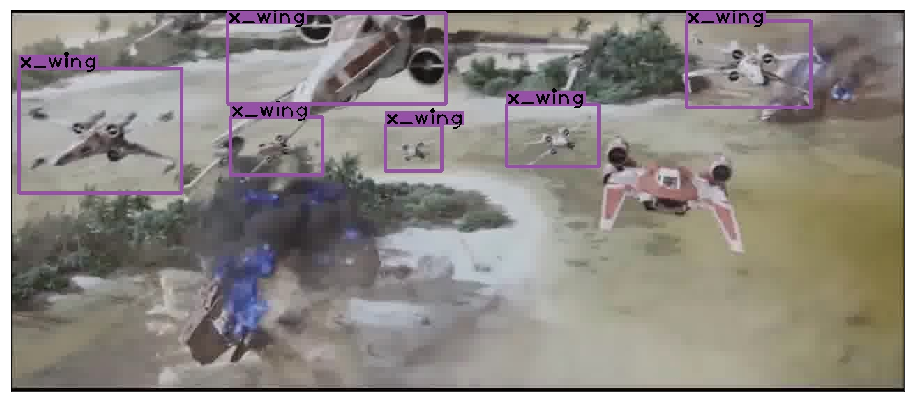

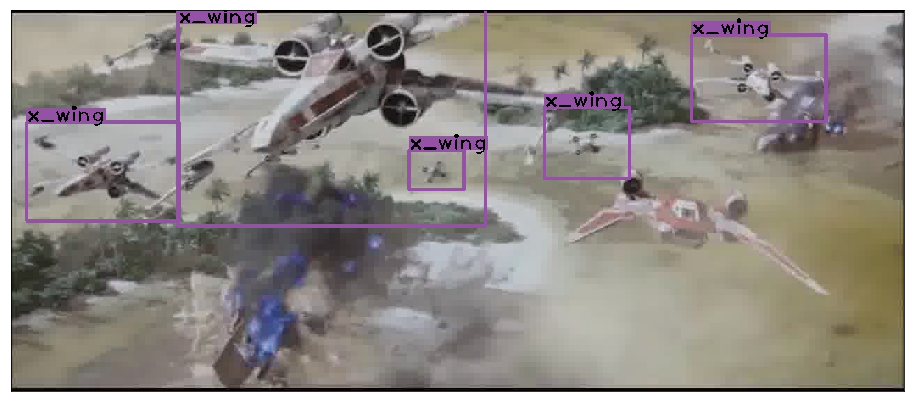

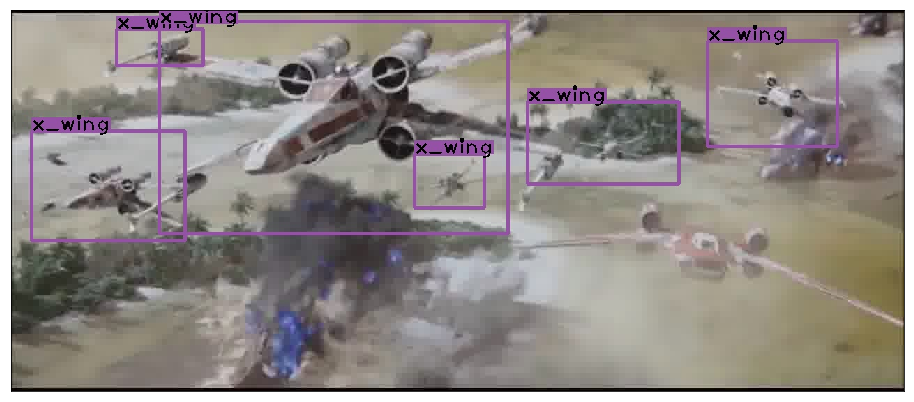

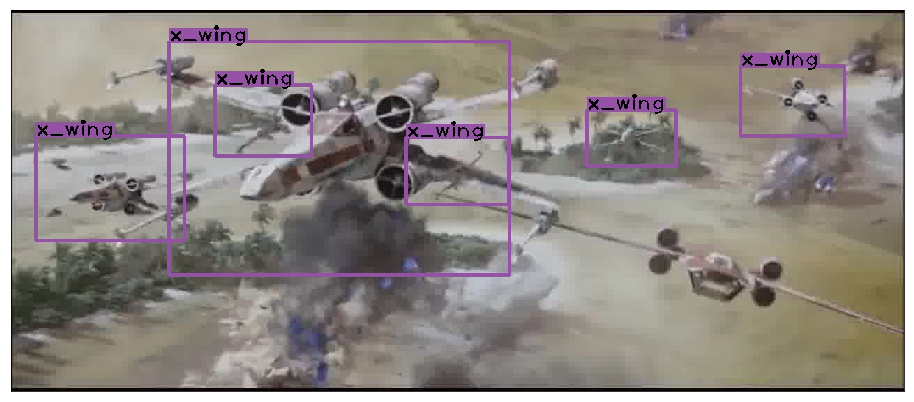

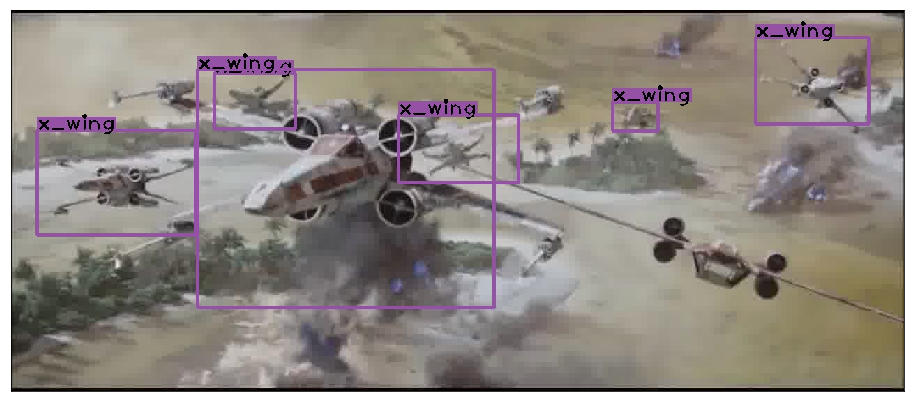

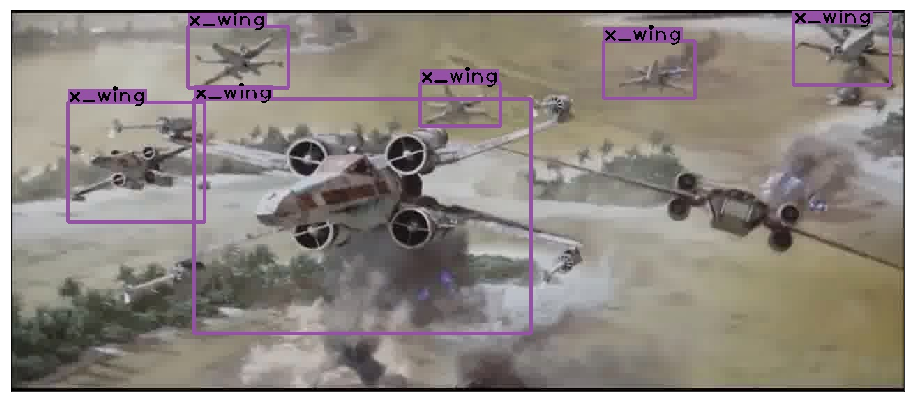

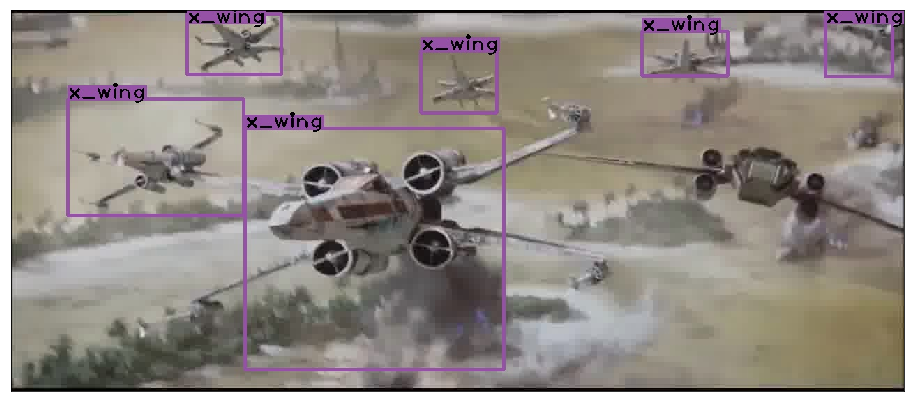

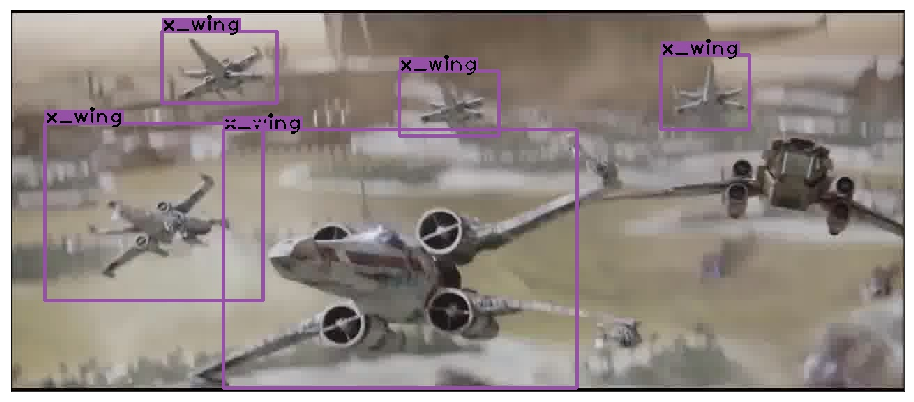

In [14]:
read_detections(output_img_dir, 0, 8)